In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras import backend as K
%matplotlib inline

a = 'c:'
b = 'Users' 
c = 'dubem'
d = 'Documents'
e = '552'
f = 'Projects'

dsb_data_dir = os.path.join("...",'/Users/dubem/Documents/552/Project/')
#dsb_data_dir = os.path.join(a,b,c,d,e,f)
stage_label = 'stage1'

### READ IN THE LABELS

In [4]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))

train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
20033,a891bbc89143bca7a717386144eb061ec2d599cba24681...,"[236275, 6, 236792, 13, 237310, 17, 237828, 21..."
7993,4327d27591871e9c8d317071a390d1b3dcedad05a97461...,"[121938, 10, 122296, 14, 122653, 20, 123010, 2..."
9001,4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a1856...,"[264165, 7, 264684, 10, 265201, 14, 265721, 15..."


In [5]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
#all_images = glob(os.path.join(dsb_data_dir, 'stage1_*/*/*/*'))
img_df = pd.DataFrame({'path': all_images})
#img_df = img_df.replace('/',"\\")
print(img_df.iloc[1]["path"])

/Users/dubem/Documents/552/Project\stage1_test\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac\images\0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png


### LOAD ALL THE IMAGES

In [7]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
2610,/Users/dubem/Documents/552/Project\stage1_trai...,139946af9e2c7ef4f0298e622b831dbef5e5c0cd088eb5...,masks,train,stage1
10541,/Users/dubem/Documents/552/Project\stage1_trai...,547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3c...,masks,train,stage1


### CREATE TRAINING DATA

In [8]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 56.1 s


### SHOW A FEW IMAGES

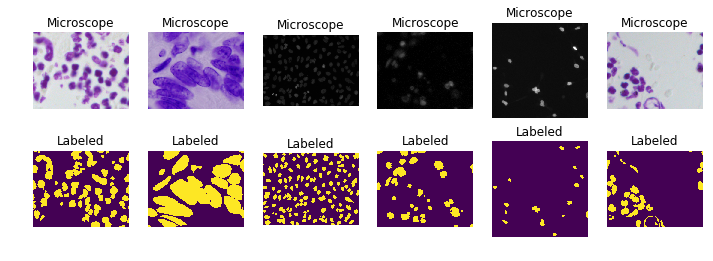

In [9]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

### CHECK DIMENSIONS

In [10]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

### Making a simple CNN
Here we make a very simple CNN just to get a quick idea of how well it works. For this we use a batch normalization to normalize the inputs. We cheat a bit with the padding to keep problems simple.

In [11]:

simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# use dilations to get a slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# the final processing
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    528       
__________

### LOSS
Since we are being evaulated with intersection over union we can use the inverse of the DICE score as the loss function to optimize

In [12]:

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

### TRAINING

In [13]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

simple_cnn.fit_generator(simple_gen(), 
                         steps_per_epoch=train_img_df.shape[0],
                        epochs = 3)

Epoch 1/3
670/670 [==============================] - 418s 624ms/step - loss: -0.6855 - dice_coef: 0.6855 - acc: 0.8584 - mean_squared_error: 0.1339
Epoch 2/3
670/670 [==============================] - 423s 632ms/step - loss: -0.7181 - dice_coef: 0.7181 - acc: 0.8830 - mean_squared_error: 0.1124
Epoch 3/3
670/670 [==============================] - 428s 638ms/step - loss: -0.7785 - dice_coef: 0.7785 - acc: 0.9215 - mean_squared_error: 0.0770


### APPLYING MODEL TO TEST

In [14]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
Wall time: 1.01 s


In [15]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

Wall time: 13.9 s


### SHOW A FEW PREDICTIONS

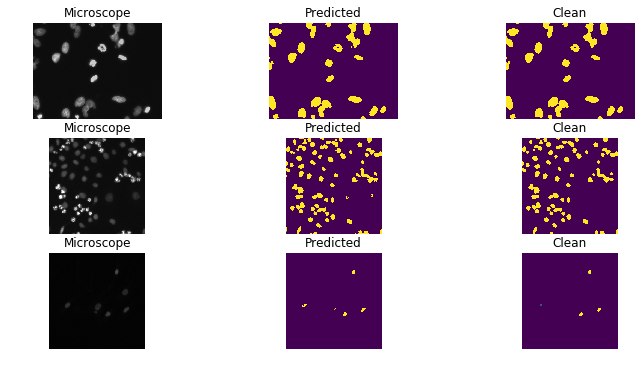

In [16]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

### CHECK RLE

In [17]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

#### Calculate the RLEs for a Train Image

In [18]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

#### Take the RLEs from the CSV

In [19]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

## CHECK
Since we made some simplifications, we don't expect everything to be perfect, but pretty close

In [21]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

#Matches: 360, Mismatches: 0, Accuracy: 1

Matches: 360, Mismatches: 0, Accuracy: 100.0%


## Calculate RLE for all the masks
Here we generate the RLE for all the masks and output the the results to a table. We use a few morphological operations to clean up the images before submission since they can be very messy (remove single pixels, connect nearby regions, etc)

In [22]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [23]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1664 regions found for 65 images


,EncodedPixels,ImageId
783,42 12 303 10 563 10 825 6,699f2992cd71e2e28cf45f81347ff22e76b37541ce8808...
1647,19637 1 19891 5 20145 9 20401 10 20656 11 2091...,fe9adb627a6f45747c5a8223b671774791ededf9364f65...
740,42285 2 42539 6 42794 9 43047 13 43301 15 4355...,697a05c6fe4a07c601d46da80885645ad574ea19b47ee7...


In [24]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)

In [25]:
c_row.rles()

TypeError: 'list' object is not callable